<a href="https://colab.research.google.com/github/ritwikraha/Open-Generative-Fill/blob/main/text_image_edits_t4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and Imports

In [ ]:
!pip install -qq --upgrade transformers diffusers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 35.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import requests
from PIL import Image
from matplotlib import pyplot as plt

import torch

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import SamModel, SamProcessor
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from diffusers import AutoPipelineForInpainting

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load the image and the text prompt

In [ ]:
image_url = "https://i.imgur.com/CiAbKbS.jpeg"
raw_image = Image.open(
    requests.get(image_url, stream=True).raw
).convert("RGB")

image = raw_image.resize((512, 512))
edit_prompt = "replace the dog with a tiger"

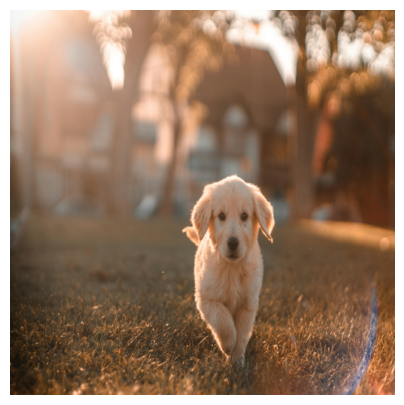

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.show()

## Extract the objects from the prompt

In [ ]:
language_model_id = "Qwen/Qwen1.5-0.5B-Chat"
language_model = AutoModelForCausalLM.from_pretrained(
    language_model_id,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(language_model_id)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
messages = [
  {"role": "system", "content": "Follow the examples and return the expected output"},
  {"role": "user", "content": "swap mountain and lion"},  # example 1
  {"role": "assistant", "content": "mountain, lion"},  # example 1
  {"role": "user", "content": "change the dog with cat"},  # example 2
  {"role": "assistant", "content": "dog, cat"},  # example 2
  {"role": "user", "content": "change the cat with a dog"},  # example 3
  {"role": "assistant", "content": "cat, dog"},  # example 3
  {"role": "user", "content": "replace the human with a boat"},  # example 4
  {"role": "assistant", "content": "human, boat"},  # example 4
  {"role": "user", "content": "in the above example change the background to the alps"},  # example 5
  {"role": "assistant", "content": "background, alps"},  # example 5
  {"role": "user", "content": "edit the house into a mansion"},  # example 6
  {"role": "assistant", "content": "house, a mansion"},  # example 6
  {"role": "user", "content": edit_prompt}
]
text = tokenizer.apply_chat_template(
  messages,
  tokenize=False,
  add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(device)

with torch.no_grad():
  generated_ids = language_model.generate(
    model_inputs.input_ids,
    max_new_tokens=512,
    temperature=0.0,
    do_sample=False
  )

  generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
  ]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


In [ ]:
response

'dog, tiger'

In [ ]:
to_replace, replace_with = response.split(", ")

In [ ]:
print(f"{to_replace=}")
print(f"{replace_with=}")

to_replace='dog'
replace_with='tiger'


In [ ]:
language_model.to("cpu")
del language_model
torch.cuda.empty_cache()

## Caption the image

In [ ]:
caption_model_id = "Salesforce/blip-image-captioning-base"
caption_model = BlipForConditionalGeneration.from_pretrained(caption_model_id).to(device)
caption_processor = BlipProcessor.from_pretrained(caption_model_id)

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
inputs = caption_processor(image, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = caption_model.generate(**inputs, max_new_tokens=200)

caption = caption_processor.decode(outputs[0], skip_special_tokens=True)

In [ ]:
caption

'a small dog running through a field of grass'

In [ ]:
replace_caption = caption.replace(to_replace, replace_with)

In [ ]:
print(f"{caption=}")
print(f"{replace_caption=}")

caption='a small dog running through a field of grass'
replace_caption='a small tiger running through a field of grass'


In [ ]:
caption_model.to("cpu")
del caption_model
torch.cuda.empty_cache()

## Build segmentation mask for inpainting

### OWL ViT

In [ ]:
owl_vit_model_id = "google/owlvit-base-patch32"
processor = OwlViTProcessor.from_pretrained(owl_vit_model_id)
od_model = OwlViTForObjectDetection.from_pretrained(owl_vit_model_id).to(device)

In [ ]:
text_queries = ["dog"]
inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = od_model(**inputs)
    target_sizes = torch.tensor([image.size]).to(device)
    results = processor.post_process_object_detection(
        outputs,
        threshold=0.1,
        target_sizes=target_sizes
    )[0]

boxes = results["boxes"].tolist()

In [ ]:
od_model.to("cpu")
del od_model
torch.cuda.empty_cache()

### SAM

In [ ]:
sam_model_id = "facebook/sam-vit-base"
seg_model = SamModel.from_pretrained(sam_model_id).to(device)
processor = SamProcessor.from_pretrained(sam_model_id)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
input_boxes = [boxes]

inputs = processor(image, input_boxes=input_boxes, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = seg_model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)

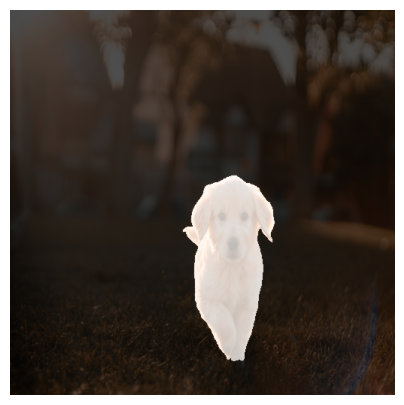

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.imshow(masks[0][0][0, :, :], alpha=0.7, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
seg_model.to("cpu")
del seg_model
torch.cuda.empty_cache()

## Output Image

### Inpain the image

In [ ]:
pipeline = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)

model_index.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [ ]:
prompt = replace_caption

negative_prompt = """lowres, bad anatomy, bad hands,
text, error, missing fingers, extra digit, fewer digits,
cropped, worst quality, low quality"""

output = pipeline(
    prompt=prompt,
    image=image,
    mask_image=Image.fromarray(masks[0][0][0, :, :].numpy()),
    negative_prompt=negative_prompt,
    guidance_scale=7.5,
    strength=0.6
).images[0]

  0%|          | 0/30 [00:00<?, ?it/s]

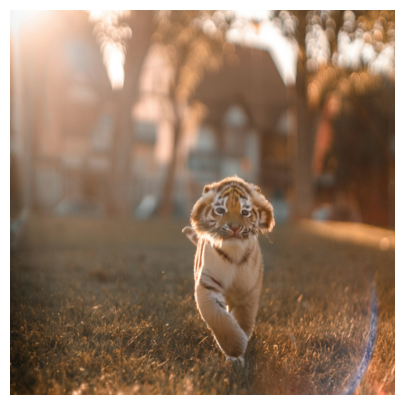

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(output)
plt.axis("off")
plt.show()

In [ ]:
pipeline.to("cpu")
del pipeline
torch.cuda.empty_cache()

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du